In [1]:
%matplotlib inline
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)


In [2]:
def add_confidence(row, agg_data):
    data = agg_data[agg_data['id'] == row['id']]
    return data.iloc[0]['label:confidence']


def load_dataset(folder):
    def add_fields(df,iteration):
        df['iteration'] = iteration
        df['domain'] = folder[0].split('-')[0]
        return df
         
    agg_list = []
    full_list = []
    test_list = []
    for f in folder:

        iteration = 2 if 'it3' in f else 1
        agg = pd.read_csv('{}/agg.csv'.format(f))
        agg = add_fields(agg,iteration)
        agg['raw_text'] = agg.apply(
        lambda row: BeautifulSoup(row['text_html'], "lxml").text.replace(':[OBJECT_A]', '').replace(':[OBJECT_B]', ''),
        axis=1)
        agg_list.append(agg)
        
        
        full = pd.read_csv('{}/full.csv'.format(f))
        full = add_fields(full,iteration)
        full_list.append(full)
        
        test = pd.read_csv('{}/test.csv'.format(f))
        test = add_fields(test,iteration)
        test_list.append(test)
    return pd.concat(agg_list), pd.concat(full_list), pd.concat(test_list)
   
        

In [3]:
jbt_agg, jbt_full, jbt_test = load_dataset(['jbt-data', 'jbt-data-it2','jbt-data-it3'])
compsci_agg, compsci_full, compsci_test = load_dataset(['compsci-data', 'compsci-data-it2', 'compsci-data-it3'])
brands_agg, brands_full, brands_test = load_dataset(['brands-data-100', 'brands-data-400', 'brands-data-it2', 'brands-data-it3'])

In [4]:
columns = ['id','domain', 'object_a', 'object_b', 'sentence', 'it_1_confidence', 'it_2_confidence', 
           'better_count', 'worse_count','none_count', 'most_frequent_label', 'most_frequent_count', 
           'it_1_judgments', 'it_2_judgments', 'sentence_html']


def add_columns(agg,full):
    df = pd.DataFrame(columns=columns)
    for sid in full['id'].unique():
        better_count = 0
        better_trust = 0
        worse_count = 0
        worse_trust = 0
        none_count = 0
        none_trust = 0
        it_1_judgments = 0
        it_2_judgments = 0
        most_frequent = ''
        f_subset = full[full['id'] == sid]
        for i, f_row in f_subset.iterrows():
            label = f_row['label']
            _iteration = f_row['iteration']
            if _iteration == 1:
                it_1_judgments +=1
            else:
                it_2_judgments += 1
                
            if 'BETTER' == label:
                better_count +=1
                better_trust += f_row['_trust']
            elif 'WORSE' == label:
                worse_count += 1
                worse_trust += f_row['_trust']
            else:
                none_count +=1
                none_trust += f_row['_trust']
        winner = sorted([(better_trust, better_count, 'BETTER'), (worse_trust, worse_count, 'WORSE'),
                         (none_trust, none_count, 'NONE')],reverse=True)
        most_frequent_label = winner[0][2]
        most_frequent_count = winner[0][1]
        
        a_it1 = agg[(agg['id'] == sid) & (agg['iteration'] == 1)]
        a_it2 = agg[(agg['id'] == sid) & (agg['iteration'] == 2)]
        

        if len(a_it1) == 1 and len(a_it2) == 1:
            content = [sid,a_it1.iloc[0]['domain'], a_it1.iloc[0]['a'], a_it1.iloc[0]['b'],a_it1.iloc[0]['raw_text'],
                       a_it1.iloc[0]['label:confidence'],a_it2.iloc[0]['label:confidence'],
                       better_count,worse_count,none_count,most_frequent_label,most_frequent_count,it_1_judgments,it_2_judgments,a_it1.iloc[0]['text_html']]
            df.loc[len(df)] =content
    
    df['judgments'] = df['it_1_judgments'] + df['it_2_judgments']
    it1_c = df['it_1_confidence'] * (df['it_1_judgments']/ df['judgments'])
    it2_c = df['it_2_confidence'] * (df['it_2_judgments']/ df['judgments'])
    df['confidence'] = it1_c+it2_c
    
    df['most_frequent_percentage'] = df['most_frequent_count'] / df['judgments']
    numeric_cols =['confidence', 'most_frequent_count', 'most_frequent_percentage','judgments']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

    
    return df

In [5]:
compsci = add_columns(compsci_agg,compsci_full)

In [6]:
brands = add_columns(brands_agg,brands_full)

In [7]:
jbt = add_columns(jbt_agg,jbt_full)

In [8]:
combi = pd.concat([compsci,brands,jbt])

In [9]:
print('All rows: {} Unique: {}'.format(len(combi), len(combi['sentence'])))

All rows: 7275 Unique: 7275


1378
597
5300


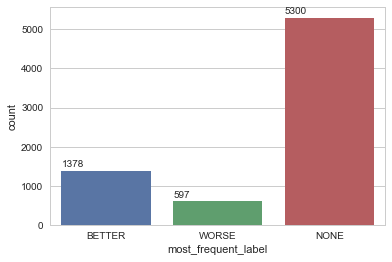

In [27]:
ax = sns.countplot(x="most_frequent_label", data=combi);
for p in ax.patches:
    print(p.get_height())    
    ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()+100))


In [11]:
from sklearn.model_selection import train_test_split

train_i, test_i = train_test_split(combi,stratify=combi['most_frequent_label'], test_size=0.2,random_state=42)
print('{} {} {}'.format(len(train_i), len(test_i), (len(train_i)+ len(test_i))))
combi.to_csv('all-data.csv',index=False)
train_i.to_csv('data.csv',index=False)
test_i.to_csv('held-out-data.csv',index=False)

5820 1455 7275


In [12]:
combi

,id,domain,object_a,object_b,sentence,it_1_confidence,it_2_confidence,better_count,worse_count,none_count,most_frequent_label,most_frequent_count,it_1_judgments,it_2_judgments,sentence_html,judgments,confidence,most_frequent_percentage
0,G1031319964,compsci,Ruby,PHP,I can't imagine that PHP is faster than Ruby (...,0.7138,0.5106,3,1,1,BETTER,3,3,2,"I can't imagine that <span style=""color: #9A14...",5,0.63252,0.600000
1,L1828119025,compsci,Windows XP,Windows Vista,"Note, that because of my own terrible experien...",0.6386,1.0000,0,4,1,WORSE,4,3,2,"Note, that because of my own terrible experien...",5,0.78316,0.800000
2,M1996510083,compsci,PHP,Perl,"PHP would be a much nicer, friendly and more c...",0.6533,0.5000,1,1,3,NONE,3,3,2,"<span style=""color: #9A14B2; font-weight: bold...",5,0.59198,0.600000
3,M1988300932,compsci,Java,Perl,Perl has a large user base but it is still eas...,1.0000,0.5106,0,4,1,WORSE,4,3,2,"<span style=""color: #9A14B2; font-weight: bold...",5,0.80424,0.800000
4,R2873497635,compsci,Windows 7,Windows 8,This time Windows 8 was roughly 8 percent slow...,1.0000,1.0000,0,6,0,WORSE,6,3,3,"This time <span style=""color: #9A14B2; font-we...",6,1.00000,1.000000
5,H1153354916,compsci,Java,Perl,"I haven't tried the C# and Java interfaces, bu...",1.0000,0.5106,0,1,4,NONE,4,3,2,"I haven't tried the C# and <span style=""color:...",5,0.80424,0.800000
6,H1195626804,compsci,Perl,AWK,"I'm a Perl guy myself, but sometimes AWK is fa...",1.0000,1.0000,0,5,0,WORSE,5,3,2,"I'm a <span style=""color: #9A14B2; font-weight...",5,1.00000,1.000000
7,T3239865546,compsci,PHP,JavaScript,"You can do form checking with PHP, but it is m...",1.0000,1.0000,0,5,0,WORSE,5,3,2,"You can do form checking with <span style=""col...",5,1.00000,1.000000
8,T3281768598,compsci,PHP,JavaScript,You will want some JavaScript (or JQuery) and ...,0.3721,1.0000,0,3,2,WORSE,3,3,2,"You will want some <span style=""color: #9A14B2...",5,0.62326,0.600000
9,H1158795912,compsci,PHP,Perl,"I have written similar mechanisms in Perl, but...",1.0000,1.0000,0,5,0,WORSE,5,3,2,I have written similar mechanisms in <span sty...,5,1.00000,1.000000
